In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


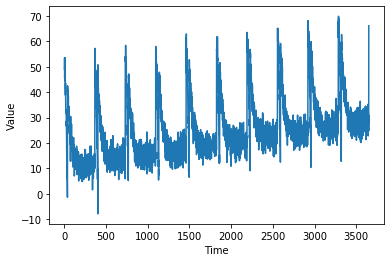

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



plot_series(time, series)

In [3]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
len(x_train)

3000

In [17]:
def to_dataset(a, window_size):
    d=[]
    x=[]
    y=[]
    for i in range(len(a)-window_size-1):
        d.append(a[i:i+window_size+1])
    np.random.shuffle(d)
    for dd in d:
        x.append(dd[:-1])
        y.append(dd[-1:])
    return np.array(x), np.array(y)

In [18]:
X_train, y_train = to_dataset(x_train, window_size)
X_valid, y_valid = to_dataset(x_valid, window_size)

In [21]:
X_train = X_train.reshape((-1, 20, 1))
X_valid = X_valid.reshape((-1, 20, 1))

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Bidirectional, Lambda
from tensorflow.keras.optimizers import Adam

In [10]:
lrs=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10.0 ** (epoch//20*1.0))

In [41]:
model = Sequential([
    Bidirectional(LSTM(64, input_shape=(None, 20, 1), return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1),
    Lambda(lambda x:x*100)
])

In [42]:
model.compile(loss='mse', optimizer=Adam(lr=1e-5), metrics=['mse'])

In [43]:
history=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, callbacks=[lrs])

Epoch 1/100
94/94 [==============================] - 2s 21ms/step - loss: 4044.3752 - mse: 4044.3752 - val_loss: 4645.0454 - val_mse: 4645.0454 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 10ms/step - loss: 4034.9541 - mse: 4034.9541 - val_loss: 4635.1064 - val_mse: 4635.1064 - lr: 1.0000e-08
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 4025.5588 - mse: 4025.5588 - val_loss: 4625.2012 - val_mse: 4625.2012 - lr: 1.0000e-08
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 4016.1809 - mse: 4016.1809 - val_loss: 4615.3164 - val_mse: 4615.3164 - lr: 1.0000e-08
Epoch 5/100
94/94 [==============================] - 1s 11ms/step - loss: 4006.8020 - mse: 4006.8020 - val_loss: 4605.4185 - val_mse: 4605.4185 - lr: 1.0000e-08
Epoch 6/100
94/94 [==============================] - 1s 11ms/step - loss: 3997.4299 - mse: 3997.4299 - val_loss: 4595.5356 - val_mse: 4595.5356 - lr: 1.0000e-08
Epoch 7/100
94/94 [===============

Epoch 52/100
94/94 [==============================] - 1s 10ms/step - loss: 128.1011 - mse: 128.1011 - val_loss: 177.1804 - val_mse: 177.1804 - lr: 1.0000e-06
Epoch 53/100
94/94 [==============================] - 1s 9ms/step - loss: 117.3055 - mse: 117.3055 - val_loss: 155.1810 - val_mse: 155.1810 - lr: 1.0000e-06
Epoch 54/100
94/94 [==============================] - 1s 9ms/step - loss: 109.4345 - mse: 109.4345 - val_loss: 138.2931 - val_mse: 138.2931 - lr: 1.0000e-06
Epoch 55/100
94/94 [==============================] - 1s 9ms/step - loss: 103.5005 - mse: 103.5005 - val_loss: 125.0792 - val_mse: 125.0792 - lr: 1.0000e-06
Epoch 56/100
94/94 [==============================] - 1s 9ms/step - loss: 98.8586 - mse: 98.8586 - val_loss: 114.8077 - val_mse: 114.8077 - lr: 1.0000e-06
Epoch 57/100
94/94 [==============================] - 1s 10ms/step - loss: 94.9231 - mse: 94.9231 - val_loss: 106.2100 - val_mse: 106.2100 - lr: 1.0000e-06
Epoch 58/100
94/94 [==============================] - 1s 9ms

In [44]:
# model = Sequential([
#     Bidirectional(LSTM(64, input_shape=(None, 20, 1), return_sequences=True)),
#     Bidirectional(LSTM(64)),
#     Dense(64, activation='relu'),
#     Dense(1),
#     Lambda(lambda x:x*100)
# ])
model.compile(loss='mse', optimizer=Adam(lr=1e-6), metrics=['mse'])

In [45]:
history=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100)

Epoch 1/100
94/94 [==============================] - 2s 19ms/step - loss: 21.9761 - mse: 21.9761 - val_loss: 20.7743 - val_mse: 20.7743
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8847 - mse: 21.8847 - val_loss: 20.9077 - val_mse: 20.9077
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8737 - mse: 21.8737 - val_loss: 20.5900 - val_mse: 20.5900
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8939 - mse: 21.8939 - val_loss: 20.9154 - val_mse: 20.9154
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8717 - mse: 21.8717 - val_loss: 20.8610 - val_mse: 20.8610
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8629 - mse: 21.8629 - val_loss: 21.0405 - val_mse: 21.0405
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 21.8590 - mse: 21.8590 - val_loss: 20.5884 - val_mse: 20.5884
Epoch 8/100
94/94 [==============================] - 1

94/94 [==============================] - 1s 8ms/step - loss: 21.6991 - mse: 21.6991 - val_loss: 20.4754 - val_mse: 20.4754
Epoch 62/100
94/94 [==============================] - 1s 8ms/step - loss: 21.6869 - mse: 21.6869 - val_loss: 20.4733 - val_mse: 20.4733
Epoch 63/100
94/94 [==============================] - 1s 8ms/step - loss: 21.6832 - mse: 21.6832 - val_loss: 20.4803 - val_mse: 20.4803
Epoch 64/100
94/94 [==============================] - 1s 8ms/step - loss: 21.6933 - mse: 21.6933 - val_loss: 20.6468 - val_mse: 20.6468
Epoch 65/100
94/94 [==============================] - 1s 9ms/step - loss: 21.6722 - mse: 21.6722 - val_loss: 20.6797 - val_mse: 20.6797
Epoch 66/100
94/94 [==============================] - 1s 9ms/step - loss: 21.6526 - mse: 21.6526 - val_loss: 20.3004 - val_mse: 20.3004
Epoch 67/100
94/94 [==============================] - 1s 10ms/step - loss: 21.6926 - mse: 21.6926 - val_loss: 20.6018 - val_mse: 20.6018
Epoch 68/100
94/94 [==============================] - 1s 9ms

In [47]:
model.compile(loss='mae', optimizer=Adam(lr=1e-6), metrics=['mae'])
history=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100)

Epoch 1/100
94/94 [==============================] - 2s 20ms/step - loss: 3.0467 - mae: 3.0467 - val_loss: 3.1078 - val_mae: 3.1078
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0434 - mae: 3.0434 - val_loss: 3.0924 - val_mae: 3.0924
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0421 - mae: 3.0421 - val_loss: 3.0989 - val_mae: 3.0989
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0405 - mae: 3.0405 - val_loss: 3.1252 - val_mae: 3.1252
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0406 - mae: 3.0406 - val_loss: 3.1350 - val_mae: 3.1350
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0408 - mae: 3.0408 - val_loss: 3.1037 - val_mae: 3.1037
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0413 - mae: 3.0413 - val_loss: 3.1110 - val_mae: 3.1110
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0380 - 

Epoch 63/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0211 - mae: 3.0211 - val_loss: 3.0755 - val_mae: 3.0755
Epoch 64/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0253 - mae: 3.0253 - val_loss: 3.0811 - val_mae: 3.0811
Epoch 65/100
94/94 [==============================] - ETA: 0s - loss: 3.0273 - mae: 3.027 - 1s 10ms/step - loss: 3.0230 - mae: 3.0230 - val_loss: 3.0726 - val_mae: 3.0726
Epoch 66/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0235 - mae: 3.0235 - val_loss: 3.0694 - val_mae: 3.0694
Epoch 67/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0221 - mae: 3.0221 - val_loss: 3.0827 - val_mae: 3.0827
Epoch 68/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0205 - mae: 3.0205 - val_loss: 3.0758 - val_mae: 3.0758
Epoch 69/100
94/94 [==============================] - 1s 10ms/step - loss: 3.0209 - mae: 3.0209 - val_loss: 3.0712 - val_mae: 3.0712
Epoch 70/100
94/94 [===========

In [49]:
X_pred=model.predict(X_valid)

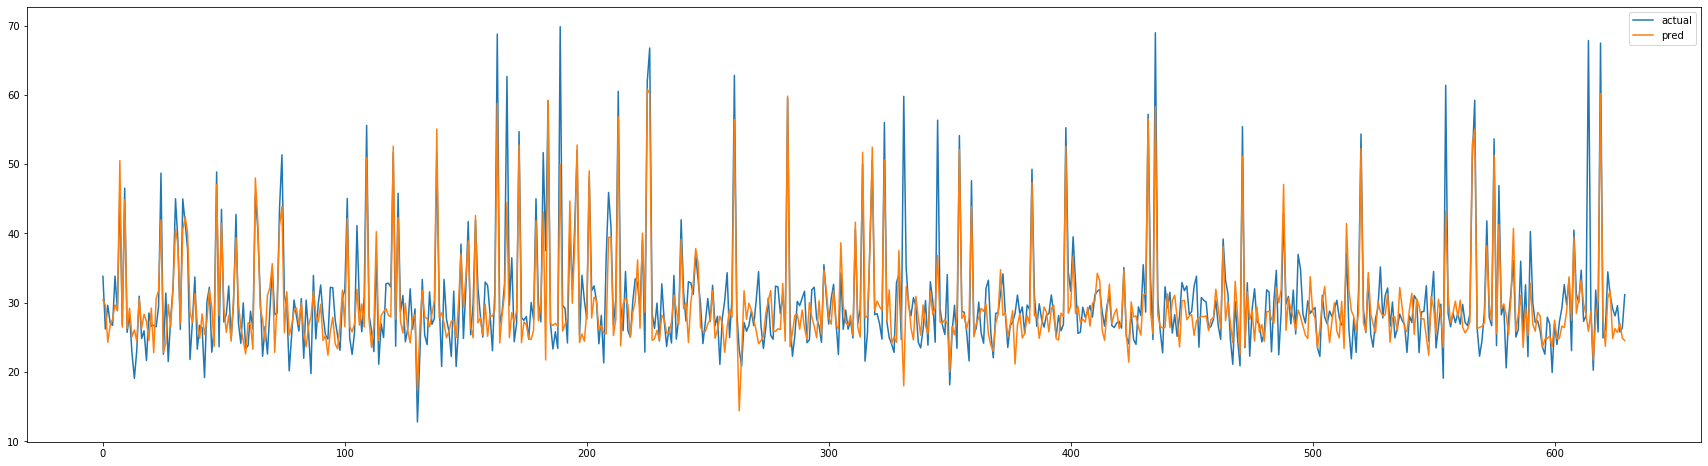

In [55]:
plt.figure(figsize=(30,8))
plt.plot(y_valid, label='actual')
plt.plot(X_pred, label='pred')
plt.legend()
plt.show()